In [1]:
# Title: Biomedical NER and SDoH Extraction from PubMed Abstracts

# --------------------------- 1. Setup and Imports ---------------------------

# Install necessary libraries with numpy version <2.0.0
!pip install transformers torch nltk seqeval spacy tqdm matplotlib numpy<2.0.0

# Download spaCy English model
!python -m spacy download en_core_web_sm

# Import libraries
import json
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import nltk
from tqdm import tqdm
import spacy
from collections import Counter
import matplotlib.pyplot as plt

# Optional: Ensure that NLTK data is downloaded
nltk.download('punkt')

zsh:1: no such file or directory: 2.0.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 14.8 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


/Users/Tim/PycharmProjects/NII_Oxford_Project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /Users/Tim/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:

# Load the dataset
# Update the filename to match your actual JSON file
with open('../MS_SDoH_pubmed_abstracts_20241127.json', 'r', encoding='utf-8') as f:
    articles = json.load(f)

In [3]:

# Load BioBERT NER model and tokenizer
model_name = "d4data/biomedical-ner-all"  # Correct model name as per user

try:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    ner_model = AutoModelForTokenClassification.from_pretrained(model_name)
    print("BioBERT NER model and tokenizer loaded successfully.")
except Exception as e:
    print(f"Error loading model '{model_name}': {e}")
    # Exit the notebook if model loading fails
    import sys
    sys.exit()

# Create NER pipeline
# Use GPU if available
device = 0 if torch.cuda.is_available() else -1
ner_pipeline = pipeline("ner", model=ner_model, tokenizer=tokenizer, aggregation_strategy="simple", device=device)
print(f"Using device: {'GPU' if device == 0 else 'CPU'}")


BioBERT NER model and tokenizer loaded successfully.
Using device: CPU


In [5]:
# Test the NER pipeline on a sample sentence
test_sentence = "The patient reported no recurrence of palpitations at follow-up 6 months after the ablation."

print("\nTesting NER pipeline with a sample sentence...")
try:
    test_entities = ner_pipeline(test_sentence)
    print("Test sentence entities:")
    print(json.dumps(test_entities, indent=4))
except Exception as e:
    print(f"Error during NER pipeline test: {e}")



Testing NER pipeline with a sample sentence...
Test sentence entities:
Error during NER pipeline test: Object of type float32 is not JSON serializable


Processing abstracts: 100%|██████████| 523/523 [01:34<00:00,  5.53it/s]


Entity Counts:
Disease_disorder: 4286
Diagnostic_procedure: 2448
Sign_symptom: 961
Coreference: 484
Detailed_description: 1328
Lab_value: 809
Nonbiological_location: 37
Duration: 71
Clinical_event: 16
Medication: 219
Biological_structure: 309
Date: 39
Quantitative_concept: 24
History: 94
Severity: 42
Activity: 80
Personal_background: 151
Family_history: 67
Therapeutic_procedure: 97
Other_event: 13
Sex: 30
Age: 31
Shape: 1
Subject: 81
Occupation: 2
Dosage: 4
Administration: 14
Outcome: 7
Other_entity: 3
Frequency: 5
Area: 2
Distance: 2
Qualitative_concept: 3


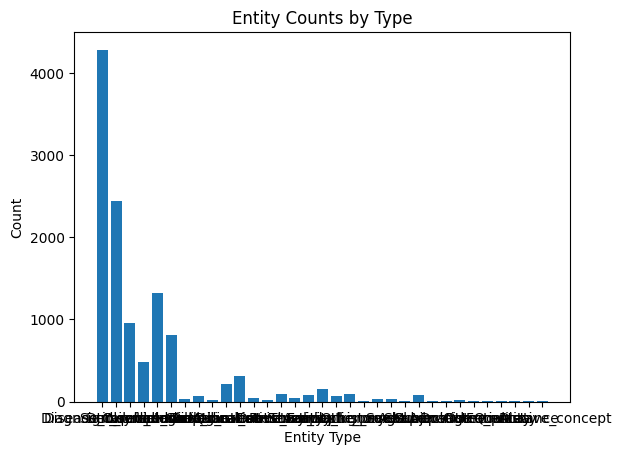

Extracting SDoH mentions: 100%|██████████| 523/523 [00:14<00:00, 36.91it/s]



SDoH Mentions Counts:
age: 191
stress: 53
education: 24
income: 28
lifestyle: 41
environment: 33
Gender: 3
nutrition: 6
race: 25
ethnicity: 29
gender: 23
Age: 7
discrimination: 6
Lifestyle: 2
Race: 6
employment: 10
Environment: 1
geography: 1
Stress: 3
Education: 1
Nutrition: 1
Violence: 2
violence: 14
urban: 8
enviRonment: 1


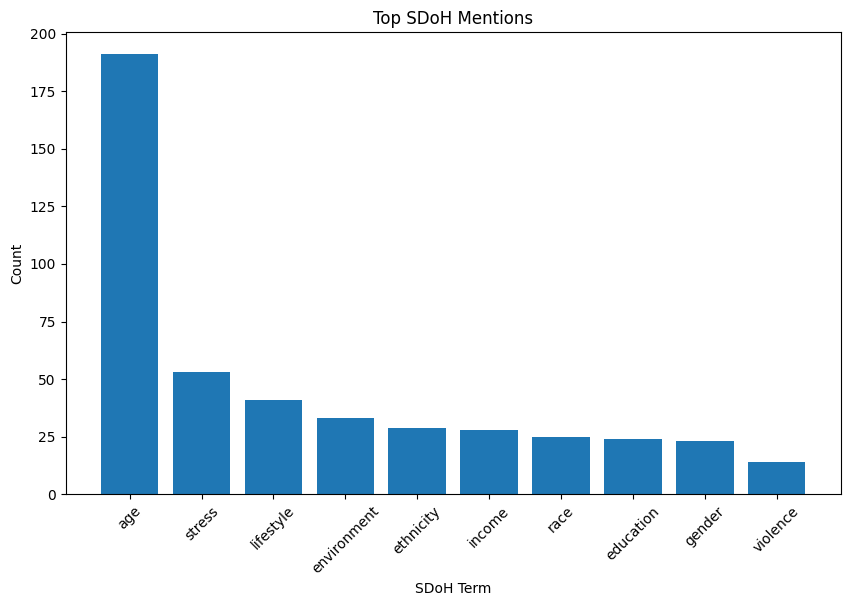

TypeError: Object of type float32 is not JSON serializable

In [6]:
import numpy as np  # Import NumPy
# Initialize a list to hold all entities
all_entities = []

# Process each article
for article in tqdm(articles, desc="Processing abstracts"):
    abstract = article.get('abstract', '')
    if abstract:
        # Perform NER
        entities = ner_pipeline(abstract)
        # Add entities to the article data
        article['entities'] = entities
        # Collect all entities
        all_entities.extend(entities)
    else:
        article['entities'] = []

# Count entity types
entity_labels = [entity['entity_group'] for entity in all_entities]
entity_counts = Counter(entity_labels)

print("Entity Counts:")
for label, count in entity_counts.items():
    print(f"{label}: {count}")

# Optional: Plot entity counts
labels, counts = zip(*entity_counts.items())
plt.bar(labels, counts)
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.title('Entity Counts by Type')
plt.show()

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Example list of SDoH keywords (this list can be expanded)
sdoh_keywords = [
    'poverty', 'education', 'housing', 'nutrition', 'employment', 'social support',
    'income', 'discrimination', 'environment', 'stress', 'violence', 'access to care',
    'lifestyle', 'geography', 'latitude', 'urban', 'rural', 'ethnicity', 'race', 'pollution'
]

# Convert to lowercase for matching
sdoh_keywords = [kw.lower() for kw in sdoh_keywords]

# Initialize a list to hold all SDoH mentions
all_sdoh_mentions = []

for article in tqdm(articles, desc="Extracting SDoH mentions"):
    abstract = article.get('abstract', '')
    sdoh_mentions = []
    if abstract:
        doc = nlp(abstract)
        for token in doc:
            if token.text.lower() in sdoh_keywords:
                sdoh_mentions.append(token.text)
        # Add SDoH mentions to the article data
        article['sdoh_mentions'] = sdoh_mentions
        # Collect all SDoH mentions
        all_sdoh_mentions.extend(sdoh_mentions)
    else:
        article['sdoh_mentions'] = []

# Count SDoH mentions
sdoh_counts = Counter(all_sdoh_mentions)

print("\nSDoH Mentions Counts:")
for sdoh, count in sdoh_counts.items():
    print(f"{sdoh}: {count}")

# Optional: Plot top SDoH mentions
top_sdoh = sdoh_counts.most_common(10)
sdoh_labels, sdoh_counts_values = zip(*top_sdoh)
plt.figure(figsize=(10, 6))
plt.bar(sdoh_labels, sdoh_counts_values)
plt.xlabel('SDoH Term')
plt.ylabel('Count')
plt.title('Top SDoH Mentions')
plt.xticks(rotation=45)
plt.show()
